In [1]:
import numpy
import qubit_matmul
import scipy.sparse
from matplotlib import pyplot
import os

# Make XXZ model

In [2]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szi = numpy.kron(sz,numpy.eye(2))
siz = numpy.kron(numpy.eye(2),sz)

def make_ladder(l,jrung,jrail,hz):
    terms = []
    
    hrung = jrung*(spm + smp + szz)
    hrail = jrail*(spm + smp + szz)
    hz = sz * hz
    
    for i in range(l//2):
        a = 2*i
        b = 2*i + 1
        c = 2*(i+1) % (l//2)
        d = (2*(i+1) + 1) % (l//2)
        print(a,b,c,d)
        
        terms.append(qubit_matmul.TensorMatf64([a, b], hrung.flatten()))
        terms.append(qubit_matmul.TensorMatf64([a, c], hrail.flatten()))
        terms.append(qubit_matmul.TensorMatf64([b, d], hrail.flatten()))
        
    for i in range(l):
        terms.append(qubit_matmul.TensorMatf64([i], hz.flatten()))
        
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc


def make_xxz_ham(l,jz,hz=0.0):
    terms = []
    
    interaction = -(spm + smp) + jz*szz
    hz = sz * hz
    
    for i in range(l):
        a = i
        b = (i+1)%l
        
        terms.append(qubit_matmul.TensorMatf64([a, b], interaction.flatten()))
        terms.append(qubit_matmul.TensorMatf64([i], hz.flatten()))
        
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

In [3]:
l = 10
ham = make_xxz_ham(l,-0.5)

ham = ham.get_sparse(l)

vals, vecs = scipy.sparse.linalg.eigsh(ham,k=1)

gs = vecs[:,0]

In [4]:
# Check half filling
data = []
for i,x in enumerate(gs):
    if abs(x) > 1e-10:
        data.append(bin(i)[2:].zfill(l).count('1'))
assert(all(map(lambda x: x==l//2, data)))

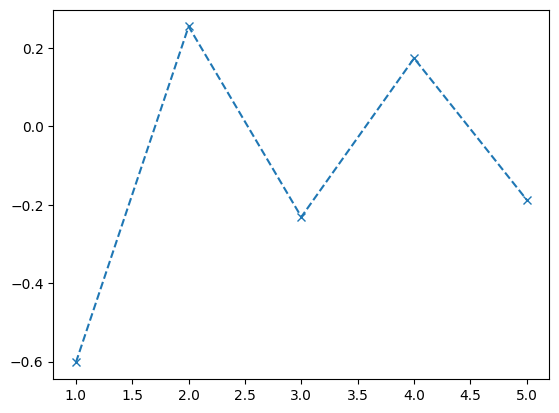

In [5]:
data = []
dist = numpy.arange(1,l//2+1)
for i in dist:
    corr_check = make_zz(0,i).get_sparse(l)
    data.append(gs @ (corr_check @ gs))

pyplot.plot(dist,data,'x--')

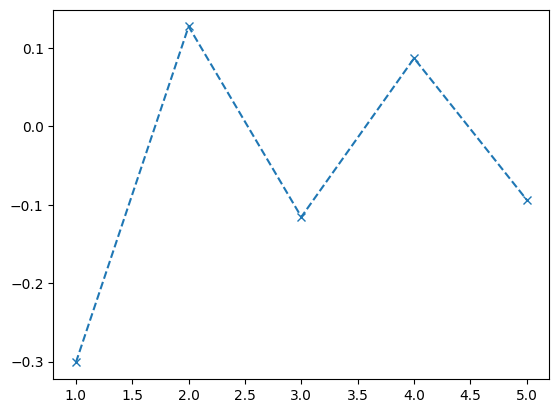

In [6]:
datah = []
disth = numpy.arange(1,l//2 + 1)

for i in disth:
    corr_check = make_pm(0,i).get_sparse(l)
    datah.append(gs @ (corr_check @ gs))

pyplot.plot(disth,datah,'x--')

# Reconstruction

In [7]:
import shadow_reconstruction
import qutip as qt

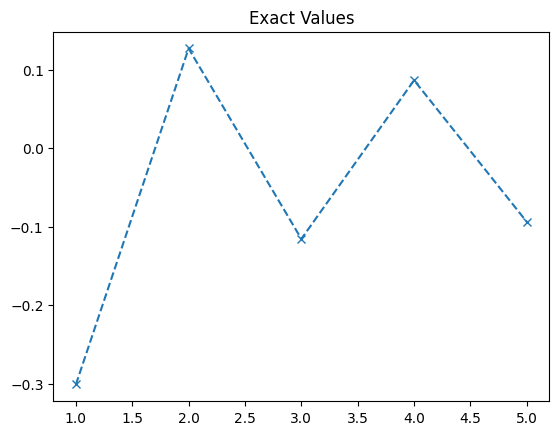

In [8]:
rho = shadow_reconstruction.DensityMatrix.new_pure_dense(gs.astype(numpy.complex128))

datah = []
disth = numpy.arange(1,l//2 + 1)

for i in disth:
    string = ['I'] * l
    string[0] = '+'
    string[i] = '-'
    string = ''.join(string)
    x = rho.expectation_string(string)
    
    datah.append(x.real)

pyplot.title('Exact Values')
pyplot.plot(disth,datah,'x--')
pyplot.show()

In [9]:
exp = shadow_reconstruction.Experiment(l)
samples = exp.sample(rho, 100_000)

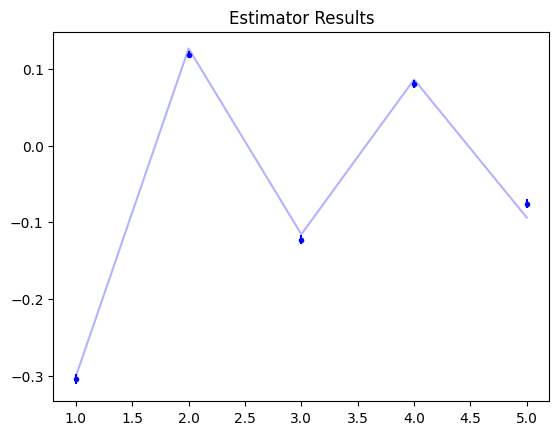

In [10]:
recon = shadow_reconstruction.Reconstruction(True)

new_datah = []
new_datah_std = []

for i in disth:
    string = ['I'] * l
    string[0] = '+'
    string[i] = '-'
    string = ''.join(string)
    x = recon.estimate_string_for_each_sample(string, samples)
    
    new_datah.append(x.real.mean())
    new_datah_std.append(x.real.std()/numpy.sqrt(len(x)))
    
pyplot.title('Estimator Results')
pyplot.errorbar(disth,new_datah,yerr=new_datah_std,fmt='.',c='blue')
pyplot.plot(disth,datah,'-',c='blue',alpha=0.3)
pyplot.show()

# Go through phases

In [56]:
def plot_data(l, j):
    ham = make_xxz_ham(l,j)
    ham = ham.get_sparse(l)
    vals, vecs = scipy.sparse.linalg.eigsh(ham,k=1)
    gs = vecs[:,0]
    
    # Check half filling
    data = []
    for i,x in enumerate(gs):
        if abs(x) > 1e-10:
            data.append(bin(i)[2:].zfill(l).count('1'))
    assert(all(map(lambda x: x==l//2, data)))
    
    datah = []
    disth = numpy.arange(1,l//2 + 1)

    for i in disth:
        corr_check = make_pm(0,i).get_sparse(l)
        datah.append(abs(gs @ (corr_check @ gs)))

    pyplot.plot(disth,datah,'x--', label=r"L={}, $\Delta$={:.1f}".format(l,j))

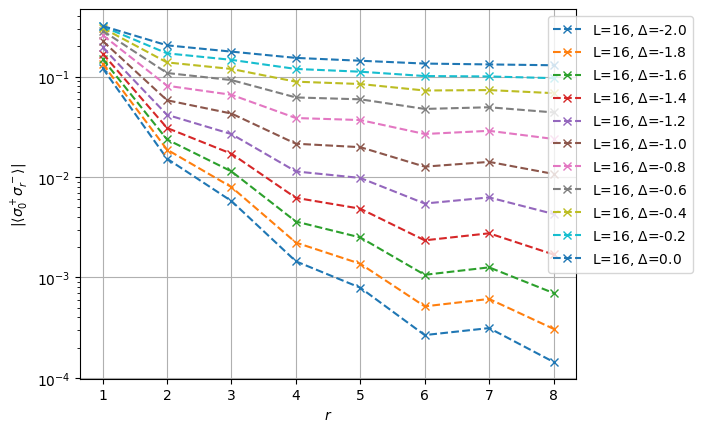

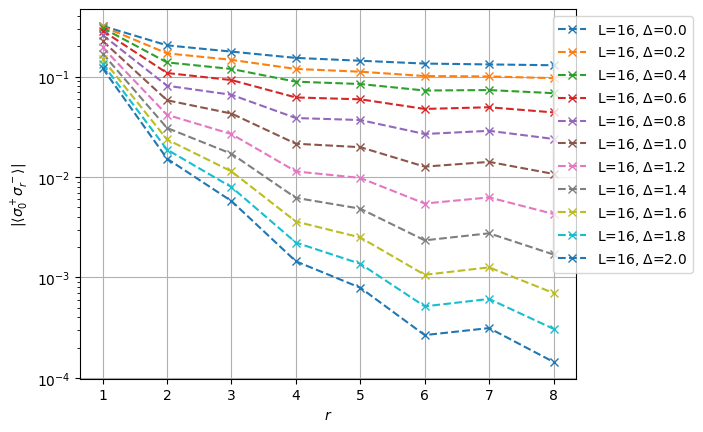

In [59]:
l = 16

for j in numpy.linspace(-2, 0, 11):
    plot_data(l,j)
pyplot.yscale('log')
pyplot.ylabel(r'$|\langle \sigma^+_0 \sigma^-_r \rangle|$')
pyplot.xlabel(r'$r$')
pyplot.grid()
pyplot.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
pyplot.show()

for j in numpy.linspace(0, 2, 11):
    plot_data(l,j)
pyplot.yscale('log')
pyplot.ylabel(r'$|\langle \sigma^+_0 \sigma^-_r \rangle|$')
pyplot.xlabel(r'$r$')
pyplot.grid()
pyplot.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
pyplot.show()

# Corr

In [18]:
def make_data(l, j, r, nsamples=10_000):
    ham = make_xxz_ham(l,j)
    ham = ham.get_sparse(l)
    vals, vecs = scipy.sparse.linalg.eigsh(ham,k=1)
    gs = vecs[:,0]
    
    # Check half filling
    data = []
    for i,x in enumerate(gs):
        if abs(x) > 1e-10:
            data.append(bin(i)[2:].zfill(l).count('1'))
    assert(all(map(lambda x: x==l//2, data)))
    
    corr_check = make_pm(0,r).get_sparse(l)
    ground_truth = gs @ (corr_check @ gs)
    
    rho = shadow_reconstruction.DensityMatrix.new_pure_dense(gs.astype(numpy.complex128))
    exp = shadow_reconstruction.Experiment(l)
    samples = exp.sample(rho, nsamples)
    recon = shadow_reconstruction.Reconstruction()

    ests = []
    for i in range(l):
        string = ['I'] * l
        string[i] = '+'
        string[(i+r)%l] = '-'
        string = ''.join(string)
        ests.append(recon.estimate_string(string, samples))
    return numpy.array(ests), ground_truth

In [67]:
ntrials = 32
n_samples = 2**numpy.arange(4, 20, 1)
errs = {}

for nsamples in n_samples:
    nsamples = int(nsamples)
    errs[nsamples] = []
    for _ in range(ntrials):
        ests, ground_truth = make_data(6,1.0,1,nsamples=nsamples)
        errs[nsamples].append(abs(ests.mean() - ground_truth))

In [68]:
errs = {
    k: numpy.array(v) for k,v in errs.items()
}

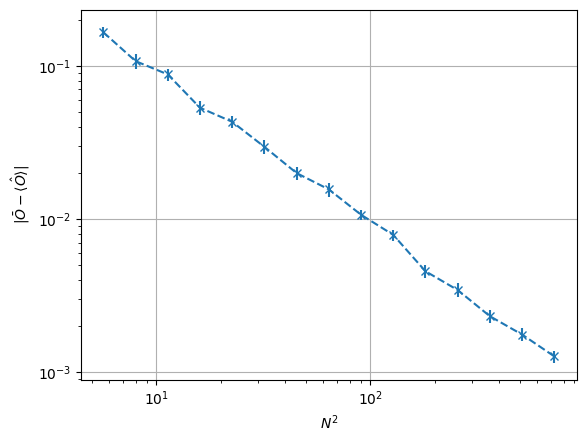

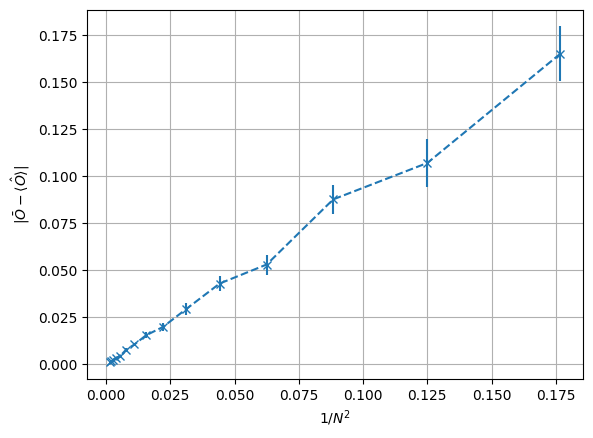

In [91]:
xvals = n_samples
yvals = numpy.array([(errs[int(n)]).mean() for n in n_samples])
ystds = numpy.array([(errs[int(n)]).std()/(ntrials**(0.5)) for n in n_samples])

pyplot.errorbar(xvals**(0.5), yvals, yerr=ystds, fmt='x--')
pyplot.grid()
pyplot.yscale('log')
pyplot.xscale('log')
pyplot.xlabel('$N^2$')
pyplot.ylabel(r'$|\bar{O} - \langle \hat{O} \rangle|$')
pyplot.show()

pyplot.errorbar(1/xvals**(0.5), yvals, yerr=ystds, fmt='x--')
pyplot.grid()
pyplot.xlabel('$1/N^2$')
pyplot.ylabel(r'$|\bar{O} - \langle \hat{O} \rangle|$')
pyplot.savefig('error_scale.pdf')
pyplot.show()

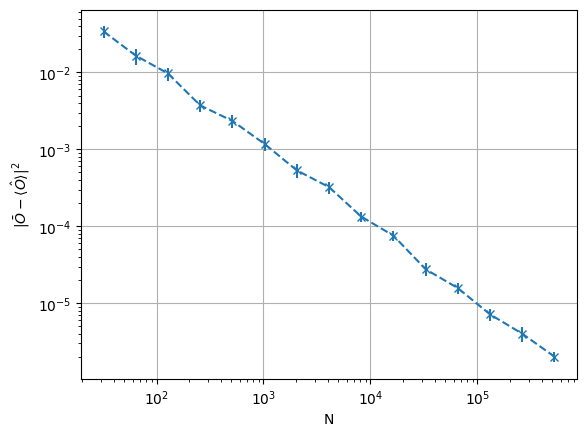

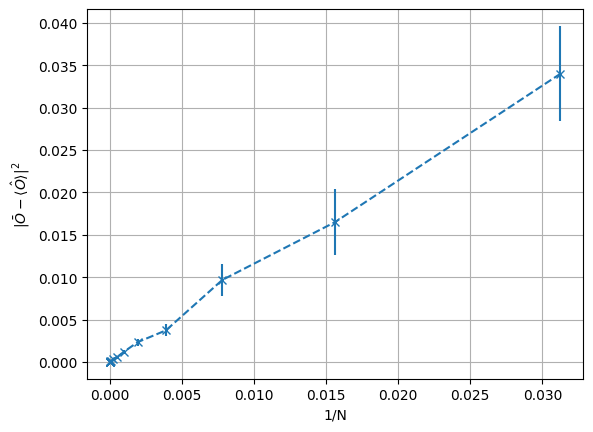

In [85]:
xvals = n_samples
yvals = numpy.array([(errs[int(n)]**2).mean() for n in n_samples])
ystds = numpy.array([(errs[int(n)]**2).std()/(ntrials**(0.5)) for n in n_samples])

pyplot.errorbar(xvals, yvals, yerr=ystds, fmt='x--')
pyplot.grid()
pyplot.yscale('log')
pyplot.xscale('log')
pyplot.xlabel('N')
pyplot.ylabel(r'$|\bar{O} - \langle \hat{O} \rangle|^2$')
pyplot.show()

pyplot.errorbar(1/xvals, yvals, yerr=ystds, fmt='x--')
pyplot.grid()
pyplot.xlabel('1/N')
pyplot.ylabel(r'$|\bar{O} - \langle \hat{O} \rangle|^2$')
pyplot.savefig('error_scale.pdf')
pyplot.show()